In [1]:
import toad
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
torch.set_default_tensor_type(torch.DoubleTensor) 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000,n_features=30,n_classes=2,random_state=328)
data = pd.DataFrame(X)
data['bad_ind'] = y
data['imei'] = [i for i in range(len(data))]
data.columns = ['f0_radius','f0_texture','f0_perimeter','f0_area','f0_smoothness',
                'f0_compactness','f0_concavity','f0_concave_points','f0_symmetry',
                'f0_fractal_dimension','f1_radius_error','f1_texture_error','f1_perimeter_error',
                'f2_area_error','f2_smoothness_error','f2_compactness_error','f2_concavity_error',
                'f2_concave_points_error','f2_symmetry_error','f2_fractal_dimension_error',
                'f3_radius','f3_texture','f3_perimeter','f3_area','f3_smoothness',
                'f3_compactness','f3_concavity','f3_concave_points','f3_symmetry',
                'f3_fractal_dimension','bad_ind','imei']

df = data.copy()
uid, dep = 'imei', 'bad_ind'
dev, off = train_test_split(df, test_size=0.3, stratify=df[dep],random_state=328)
var_names = [i for i in list(df.columns) if i not in [uid,dep]]

#构造训练与测试数据
x = torch.tensor(dev[var_names].to_numpy(),dtype=torch.double)
y = torch.tensor(dev[dep].to_numpy(),dtype=torch.double)

val_x = torch.tensor(off[var_names].to_numpy(),dtype=torch.double)
val_y = torch.tensor(off[dep].to_numpy(),dtype=torch.double)

del dev,off

In [3]:
x.shape

torch.Size([1400, 30])

In [4]:
#得到centroid
n_bins=20
trans_var_names = var_names.copy()

combiner = toad.transform.Combiner()
combiner.fit(df[trans_var_names+[dep]],df[dep],method='quantile',n_bins=n_bins,exclude=[])
bins = combiner.export()
df_bin = combiner.transform(df[trans_var_names+[dep]])

for round_num,ft in enumerate(trans_var_names):
    bin_ary=np.array([])
    for i in range(n_bins):
        if np.isnan(df[df_bin[ft]==i][ft].mean())==False:
            avg = df[df_bin[ft]==i][ft].mean()    #这'f0_area'在箱子 1 里所有的值应该都差不多，把这些值取均值可以看做箱子1的均值。
        else:                                     
            avg = -1
        bin_ary = np.append(bin_ary,avg)
    if round_num==0:
        bin_base=bin_ary.copy()
    else:
        bin_base = np.vstack((bin_base,bin_ary))
centroid=torch.tensor(bin_base,dtype=torch.double)
print(centroid.shape)                    

torch.Size([30, 20])


得到的是30个特征，每个特征分20组之后，每个组的均值，也就是每个特征有20个这样的均值，类似于直方图的感觉。
这就类似于NLP的查询词表，任何一个新的变量出现，哪怕之前没出现过，也可以落入这些箱子里，获得一个近似的表示
实在是简单精妙，梅老师已经把NLP和结构化数据的融会贯通了。

In [20]:
bin_ary#可以看出来是从低到高分布

array([-2.78916737, -2.08310666, -1.67951431, -1.41205546, -1.15787593,
       -0.91920825, -0.63981622, -0.40423327, -0.14193784,  0.08040741,
        0.25010067,  0.42894619,  0.6090681 ,  0.79579538,  0.95130746,
        1.09681123,  1.28004375,  1.46320882,  1.69024094,  2.1745589 ])

In [19]:
df[df_bin['f0_area']==1]['f0_area']#这是该变量分组1里所有的值

9      -1.543021
23     -1.594440
31     -1.702179
70     -1.540996
98     -1.474755
          ...   
1921   -1.552203
1953   -1.488140
1957   -1.592128
1958   -1.494215
1995   -1.605728
Name: f0_area, Length: 100, dtype: float64

In [21]:
df[df_bin['f0_area']==1]['f0_area'].describe()#可以看的出非常近似

count    100.000000
mean      -1.592682
std        0.078081
min       -1.732553
25%       -1.653434
50%       -1.595584
75%       -1.521919
max       -1.459754
Name: f0_area, dtype: float64

In [22]:
df[df_bin['f0_area']==2]['f0_area'].describe()#换个组看一下

count    100.000000
mean      -1.329622
std        0.060717
min       -1.457458
25%       -1.379354
50%       -1.319282
75%       -1.279766
max       -1.244516
Name: f0_area, dtype: float64

In [23]:
class EntityEmbeddingLayer(nn.Module):
    def __init__(self, config):
        super(EntityEmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(config.num_level, config.embedding_dim)
        self.centroid = config.centroid
        self.EPS=config.EPS
    def forward(self, x): 
        """
        x must be batch_size times 1
        """
        cent_hat = torch.tensor(self.centroid[0,:]).detach_().unsqueeze(1)#size(20,1)这是第一个特征的20个箱均值
        x_hat = x[:,0].unsqueeze(1).unsqueeze(1)  #size(1400,1,1)，这是第一个特征所有的取值
        d = 1.0/((x_hat-cent_hat).abs()+self.EPS)  #相当于把这1400个数每一个，分别减去这20个数,得到size(1400,20,1),再取倒数
        #相当于算每个用户，这个特征的值和20个箱均值的距离的倒数，这个值越大说明和该箱均值越接近。
        w = F.softmax(d.squeeze(2), 1)#先转化为(1400,20),然后按行做归一化，现在一行20个元素，这20个元素加起来为1
        #这是在算这个用户这个特征的值更适合进入哪一个箱子，之前越近的则越大，则softmax之后比例越大。
        v = torch.mm(w.type(torch.DoubleTensor), self.embedding.weight.type(torch.DoubleTensor))#然后把1400,20和新的embedding矩阵20，维度乘
        #这是一种类似word2vec的上下文的关系，这样embedding之后，至少这个特征越接近的两个用户这个特征的32维表征是有点像的。
        result = v.unsqueeze(1).type(torch.DoubleTensor)#上面得到了1400,维度，现在转化成1400,1,32 ，unsqueeze后面数字多少那个1就加在哪

        if x.size()[1]>1:#接下来循环对后面29个特征做同样的操作，最后返回1400,30,32，每个特征都由32维embedding来表示
            for i in range(1,x.size()[1]):
                cent_hat = torch.tensor(self.centroid[i,:]).detach_().unsqueeze(1)
                x_hat = x[:,i].unsqueeze(1).unsqueeze(1)
                d = 1.0/((x_hat-cent_hat).abs()+self.EPS)
                w = F.softmax(d.squeeze(2), 1)
                v = torch.mm(w.type(torch.DoubleTensor), self.embedding.weight.type(torch.DoubleTensor)).type(torch.DoubleTensor)
                result = torch.cat((result, v.unsqueeze(1)), 1)
        return result

In [107]:
F.softmax((1/(x[:,0].unsqueeze(1).unsqueeze(1)-torch.tensor(centroid[0,:]).detach_().unsqueeze(1)).abs()).squeeze(2),1)[0].sum()

tensor(1.)

In [110]:
x.size()

torch.Size([1400, 30])

In [24]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions

        self.num_attention_heads = config.num_attention_heads  
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        #其实就是分成了若干个小的attention结构来处理，比如embedding维度是512，头的数量是8就分成了8个结构，每个attention_head_size为64
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    #就是单纯为了把制作矩阵的head_size和seqlen(前面的32)放一起
    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        
        #计算attention
        query_layer = self.transpose_for_scores(mixed_query_layer)#均为[bs, 头数, seqlen, head_size]
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) #这里是为了生成 seqlen*seqlen的权重矩阵
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)#dim =-1和dim=2一样，都是对行做softmax
        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        ## 矩阵相乘，[bs, 头数, seqlen, seqlen]*[bs, 头数, seqlen, head_size] = [bs, 头数, seqlen, head_size]

        #维度还原
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)# 回到[bs, seqlen, 128]
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs

In [112]:
class TransformerConfig:
    def __init__(self, 
                output_attentions = True,
                n_var=64,
                num_attention_heads = 2,
                hidden_size = 24,
                attention_probs_dropout_prob = 0.1,
                hidden_dropout_prob = 0.1,
                intermediate_size = 24,
                num_level=10,
                embedding_dim=64,
                EPS=1e-7,
                centroid={}):
        self.output_attentions = output_attentions
        self.num_attention_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.hidden_dropout_prob = hidden_dropout_prob
        self.intermediate_size = intermediate_size
        self.n_var = n_var
        self.num_level=num_level
        self.embedding_dim = embedding_dim
        self.EPS=EPS
        self.centroid = centroid
class TransformerOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)#稠密链接（网络要想深且有效，dense和res二选一）
        self.LayerNorm = nn.LayerNorm(config.hidden_size)#层归一化
        self.dropout = nn.Dropout(config.hidden_dropout_prob)#dropout

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
class TransformerIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = F.relu

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states
    
class TransformerLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.EntityEmbeddingLayer=EntityEmbeddingLayer(config)
        self.attention = SelfAttention(config)
        self.intermediate = TransformerIntermediate(config)
        self.output = TransformerOutput(config)
        self.linear = nn.Linear(config.hidden_size*config.n_var, 1)
        
    def forward(self, hidden):
        result = self.EntityEmbeddingLayer(hidden.type(torch.DoubleTensor))
        self_attention_outputs = self.attention(result.type(torch.DoubleTensor))
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        intermediate_output = self.intermediate(attention_output.type(torch.DoubleTensor))#一部分走dense
        layer_output = self.output(intermediate_output.type(torch.DoubleTensor), attention_output.type(torch.DoubleTensor))
        outputs = (layer_output,) + outputs
        
        result = torch.sigmoid(self.linear(torch.flatten(layer_output.type(torch.DoubleTensor),start_dim=1)).squeeze(-1))
        
        return result

In [114]:
transformer_config = TransformerConfig(output_attentions = True,
                n_var=len(trans_var_names),
                num_attention_heads = 4,
                hidden_size = 32,
                attention_probs_dropout_prob = 0.1,
                hidden_dropout_prob = 0.1,
                intermediate_size = 32,
                num_level=n_bins,
                embedding_dim=32,
                centroid=centroid)
#self_attention = SelfAttention(transformer_config)
transformer_layer = TransformerLayer(transformer_config)
transformer_layer

TransformerLayer(
  (EntityEmbeddingLayer): EntityEmbeddingLayer(
    (embedding): Embedding(20, 32)
  )
  (attention): SelfAttention(
    (query): Linear(in_features=32, out_features=32, bias=True)
    (key): Linear(in_features=32, out_features=32, bias=True)
    (value): Linear(in_features=32, out_features=32, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (intermediate): TransformerIntermediate(
    (dense): Linear(in_features=32, out_features=32, bias=True)
  )
  (output): TransformerOutput(
    (dense): Linear(in_features=32, out_features=32, bias=True)
    (LayerNorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear): Linear(in_features=960, out_features=1, bias=True)
)

In [212]:
loss_fn = nn.BCELoss(reduction='sum')#返回梯度之和
learning_rate = 1e-4
optimizer = torch.optim.Adam(transformer_layer.parameters(), lr=learning_rate)
es=0
val_acc=0
best_acc=0
NUM_EPOCHS=500
BATCH_SIZE=256
val_accs = []
early_stop = 15
for epoch in range(NUM_EPOCHS):
    transformer_layer.train()
    for start in range(0,len(x),BATCH_SIZE):
        end = start + BATCH_SIZE
        batchX = x[start:end,:]
        batchY = y[start:end]

        # 前向传播
        y_pred = transformer_layer(batchX)
        # 计算损失
        loss = loss_fn(y_pred, batchY)             
        # 梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()                      
        # 参数自动一步更新
        optimizer.step()    
    transformer_layer.eval()    
    val_pred = transformer_layer(val_x).detach().numpy() 
    val_acc = round(roc_auc_score(val_y.detach().numpy(), val_pred),7)
    
    print('第{}个epoch'.format(epoch+1), loss.item(),"test AUC",val_acc)#这里选的是AUC，理论上也是可以改成KS值的
    val_accs.append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        es = 0   
        torch.save(transformer_layer.state_dict(), './model_state_dict.pt')
        print('找到新的最大值')
    else:
        es += 1
        print("Counter {} of {}".format(es,early_stop))
        
        if es >early_stop:
            print("Early stopping with best_acc: ", best_acc)
            break


第1个epoch 1.1200583613022728 test AUC 0.9222325
找到新的最大值
第2个epoch 0.624162557827809 test AUC 0.9225103
找到新的最大值
第3个epoch 1.148010694732697 test AUC 0.9228436
找到新的最大值
第4个epoch 0.7169197592086388 test AUC 0.9229214
找到新的最大值
第5个epoch 0.8829012011590978 test AUC 0.9226214
Counter 1 of 15
第6个epoch 0.5723595991831785 test AUC 0.9222102
Counter 2 of 15
第7个epoch 0.9871354144458523 test AUC 0.9219658
Counter 3 of 15
第8个epoch 0.45584279053635524 test AUC 0.9218547
Counter 4 of 15
第9个epoch 0.8198883530554779 test AUC 0.9217769
Counter 5 of 15
第10个epoch 0.5596944471858468 test AUC 0.9218214
Counter 6 of 15
第11个epoch 0.5189947122169758 test AUC 0.9218769
Counter 7 of 15
第12个epoch 1.0059071211272375 test AUC 0.9217436
Counter 8 of 15
第13个epoch 0.6447418319324718 test AUC 0.9217991
Counter 9 of 15
第14个epoch 0.6133249313224984 test AUC 0.9221102
Counter 10 of 15
第15个epoch 0.5209570302082251 test AUC 0.9222102
Counter 11 of 15
第16个epoch 0.49722291643659916 test AUC 0.9224214
Counter 12 of 15
第17个epoch 1.12

In [215]:
transformer_layer.load_state_dict(torch.load('model_state_dict.pt'))
transformer_layer.eval()
y_hat = transformer_layer(val_x)
print('验证集上AUC',round(roc_auc_score(val_y.numpy(), y_hat.detach().numpy()), 7))

验证集上AUC 0.9229214


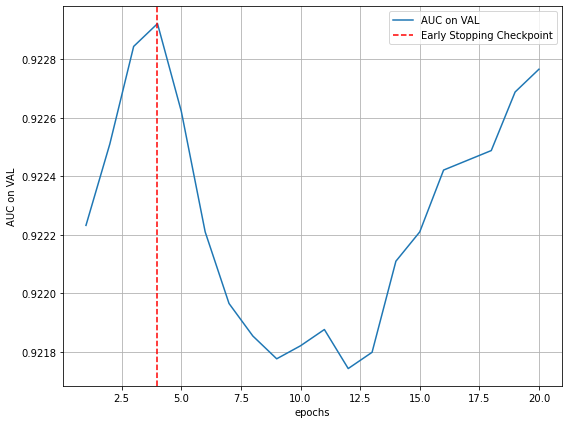

In [216]:
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(val_accs)+1),val_accs, label='AUC on VAL')
minposs = val_accs.index(max(val_accs))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('AUC on VAL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('AUC.png', bbox_inches='tight')